In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull
from math import *

PRECISION=1e-3

# some shortcuts
center = np.array([[0,0,0,0]]) # row vector. ROW VECTORS AAAAWWWW YEAH
zero = np.array([[0,0,0,0]])
x = np.array([[1,0,0,0]])
y = np.array([[0,1,0,0]])
z = np.array([[0,0,1,0]]) 
w = np.array([[0,0,0,1]]) 
basis=np.r_[x,y,z,w]

## ---- construct a tesseract. Yes, I need 30 lines of code for it ----


def extend_into_dimension(vertices,direction):
    # extends an x-dimensional facet of a cube into a specified dimension
    vertices1=vertices-direction
    vertices2=vertices+direction
    return np.r_[vertices1,vertices2] # concatenation


class Cube():
    def __init__(self,center, realm):
        # realm means 3d space. I suggest that we establish common terminology for geometry
        # realm is represented by a basis, matrix 3x4
        # center is a vector, 1x4
        self.center=center
        self.realm=realm # realm in which cube lies
    
    def __add__(self, vector):
        return Cube(self.center+vector,self.realm)
        
    def __sub__(self,vector):
        return self + (-vector)
    
    def get_vertices(self):
        # returns matrix 8x4
        vertices=self.center
        for i in range(self.realm.shape[0]):
            vertices=extend_into_dimension(vertices,self.realm[i])
        return vertices
    
    
    def get_edges(self):
        # returns list of edges, that is, matrices 2x4
        vertices = self.get_vertices()
        edges=[]
        
        # oh dear, you better just accept this as a fact
        for j in range(1,4):
            # iterating over dimensions
            #print 'j',j
            for k in range(0,8,2**j):
                #print 'k',k
                for i in range(0,2**(j-1)):
                    # iterating over vertices 
                    #print i+k, 2**(j-1)
                    edges.append(np.array([vertices[i+k],vertices[i+k+2**(j-1)]]))
            
        return edges

class Tesseract():
    
    SCALE = 0 # what does it do? we'll never know
    
    def __init__(self,center):
        self.center=center

    def get_facets(self):
        # get all 8 facets of a tesseract
        # a facet is a cube which makes one part of surface of a tesseract
        # returns list of Cubes 
        facets=[]
        for i in range(4):
            direction=basis[i] # normal to a facet
            complement = np.r_[basis[0:i],basis[i+1:]]  # all but basis[:,i]     
            facet=Cube(self.center,complement)
            #print facet
            facets.append(facet-direction)
            facets.append(facet+direction)
        return facets    


In [6]:
# Utils

def get_normal(realm):
    # returns normal to a realm
    # good but numerically unstable
    # takes basis 3x4, returns vector
    U,S,V=np.linalg.svd(realm)
    return V[3]

def intersect_realm_segment(realm, segment):
    # find a point at the intersection of a realm and a segment
    # in case when the entire segments lies on the realm, returns two endpoints
    # segment is given as matrix 2x4
    # ALWAYS returns a list of points
    
    # adapted from wikipedia https://en.wikipedia.org/wiki/Line%E2%80%93plane_intersection
    normal=get_normal(realm)
    direction=segment[1]-segment[0]
    length=np.linalg.norm(direction)
    direction=direction/length
    #print direction, normal
    if abs(direction.dot(normal)) < PRECISION:
        # segment is parallel to the realm
        if abs(segment[0].dot(normal)) < PRECISION:
            # segment is contained in the realm
            return segment
        else:
            # line is not intersecting with the realm
            return []
    else:
        # line is intersecting with the realm
        #print segment[0].dot(normal), direction.dot(normal)
        d = - segment[0].dot(normal)/direction.dot(normal)
        #print d
        if d >= 0 and d <= length:
            # segment is intersecting with the realm
            return [segment[0] + d * direction]
        else:
            return []

# tests
#print intersect_realm_segment(np.r_[x,y,z], np.array([[0.7,2,1,1],[1,1,-1,-1]]))
#print intersect_realm_segment(np.r_[x,y,z], np.array([[1,2,1,2],[1,1,-1,1]]))
#print intersect_realm_segment(np.r_[x,y,z], np.array([[1,2,1,0],[1,1,-1,0]]))
#print intersect_realm_segment(np.r_[x,y,z], np.array([[1,2,1,1],[1,1,-1,1]]))

def intersect_segments_realm(segments, realm):
    # gives an unsorted list of vertices of a polygon obtained by intersecting the segments by the realm
    
    vertices=[]
    for segment in segments:
        #print 'edge',edge
        intersection=intersect_realm_segment(realm, segment)
        #print intersection
        for vertex in intersection:
            #print vertex
            vertices.append(vertex)
        
    if not vertices:
        # Ah, the world is so imperfect
        # by the way, this runs when the list _vertices_ is empty
        return vertices
    return uniqueize(np.array(vertices))

def uniqueize(a):
    # taken from SO
    # make a matrix only contain unique rows
    b = np.ascontiguousarray(a).view(np.dtype((np.void, a.dtype.itemsize * a.shape[1])))
    _, idx = np.unique(b, return_index=True)

    return a[idx]


In [7]:
# Find faces of an intersection

from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def tess_faces(alpha,beta=0, center=zero):
    # returns Collection of 2d polygons in 3d space that together make  ...
    # the visible part of a tesseract with center in center  
    
    # now facet is a 3d thing of a tesseract, but face is a 2d thing of an intersection
    # WOW MOST DEFINITELY NOT CONFUSING
    
    t=Tesseract(center)
        
    # rotate by alpha-beta
    rot=np.array([[1,0,0,0],
                 [0,cos(alpha),0, -sin(alpha)],
                 [0,0,1,0],
                 [0,sin(alpha),0, cos(alpha)]])
    #print rot
    rot=rot.dot(np.array([[cos(beta), 0,0, -sin(beta)],
                     [0,1,0,0],
                     [0,0,1,0],
                     [sin(beta), 0,0, cos(beta)]]))
    realm=np.r_[x,y,z].dot(rot) # players' realm
    #print rot
    
    # get polygons
    faces=[]
    cols=['w','k','m','b','r','g','c','y']
    facecols=[]
    i=0
    for facet in t.get_facets():        
        face=intersect_segments_realm(facet.get_edges(),realm)
        if len(face)==0:
            continue
        
        
        #print cube
        face=face.dot(realm.T) # rotate the cube by the realm so that the intersection is now in xyz realm
        #print cube
        
        # now the scipy won't do a lower-dimensional convex hull, and in this case we have 2d in 3(4)d
        # so i project the face to a plane and run ConvexHull in the plane
        face_temp=face-face.mean(axis=0)
        #print face,face_temp
        U,S,V=np.linalg.svd(face_temp)
        face_temp=face_temp.dot(V[0:2,:].T)
        hull=ConvexHull(face_temp).vertices
        #print cube[hull]
        
        # the ConvexHull returns an ordering and i order the original guys
        face=face[np.r_[hull,hull[0]]] # also the last vertex is the repeated first one
        faces.append(face)
        facecols.append(cols[i])
        i=i+1
    return Poly3DCollection(faces,facecolors=facecols)

#print verts

#fig = plt.figure()
#ax = Axes3D(fig)
#ax.add_collection3d(tess_faces(0))
#ax.set_xlim([-3,3])
#ax.set_ylim([-3,3])
#ax.set_zlim([-3,3])
#plt.show()
 
# tes=Tesseract(x)
# tes.get_facets()[0].get_vertices()
    

<IPython.core.display.Javascript object>


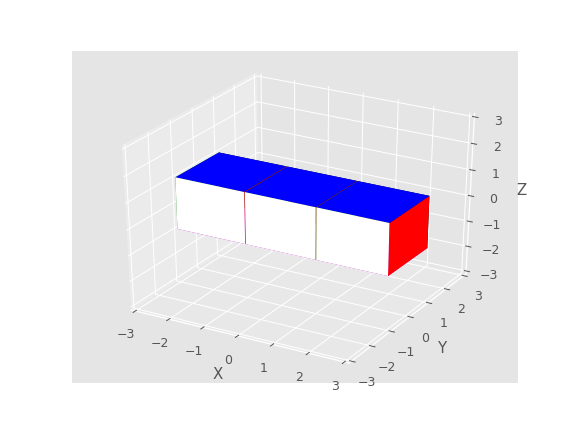

In [8]:
# plot

%matplotlib notebook
from IPython.html import widgets
from IPython.display import display
plt.style.use('ggplot')

fig=plt.figure()
ax = fig.add_subplot(111, projection='3d')

    
#X=tess_vertices(0)
#sc=ax.scatter(2*X[:,0],2*X[:,1],2*X[:,2])

# create tesseract grid
scene=[]
poses=[]
if 1:
    for i in range(3):
        for l in range(3):
            #for k in range(3):
                #for l in range(3):
            k=1
            j=1
            pos=zero + 2 * ((i-1) * x + (j-1) * y + (k-1) * z + (l-1) * w) * 1.05
            face=tess_faces(0,0,pos)
            ax.add_collection3d(face)
            scene.append(face)
            poses.append(pos)
else:
    for i in range(3):
        j=1
        k=1
        l=1
        pos=zero + 2 * ((i-1) * x + (j-1) * y + (k-1) * z + (l-1) * w) * 1.05
        face=tess_faces(0,0,pos)
        ax.add_collection3d(face)
        scene.append(face)
        poses.append(pos)

# plot limits
limit=3
ax.set_xlim([-limit,limit])
ax.set_ylim([-limit,limit])
ax.set_zlim([-limit,limit])
    
# this function gets called when someone changes value on the dialer below
def fac(alpha,beta):
    global scene,poses
    
    for i in range(len(poses)):
        scene[i].remove()
        face=tess_faces(alpha,beta,poses[i])
        ax.add_collection3d(face)
        scene[i]=face
    #ax.scatter(X[:,0],X[:,1],X[:,2])
    #plt.draw()
    fig.canvas.draw()
    
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()



In [9]:
# you neeed to run the cell above and then this cell
# after that you can actually interact with the graph
widgets.interact(fac,  alpha=(0.0,2*pi,0.1),beta=(0.0,2*pi,0.1))